shuffling the dataset


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


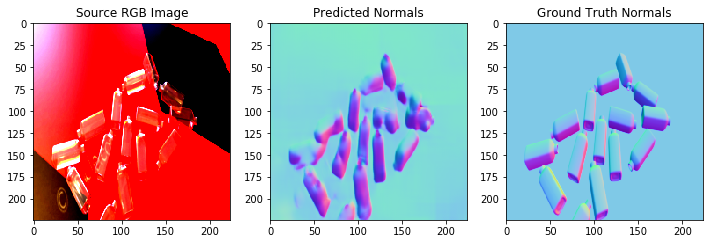

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


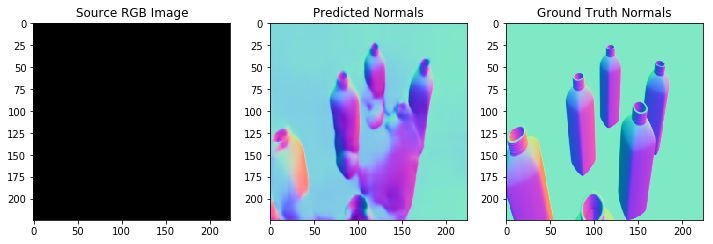

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


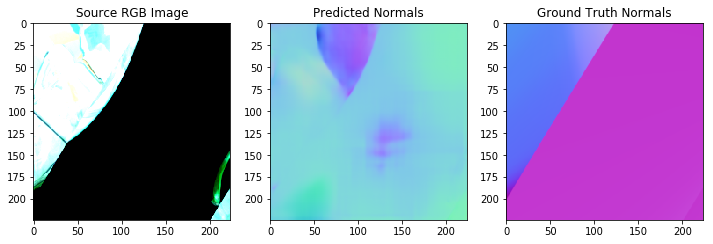

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


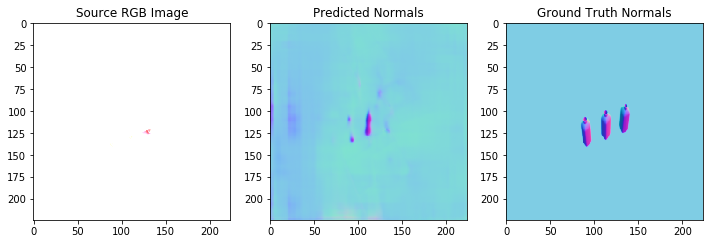

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


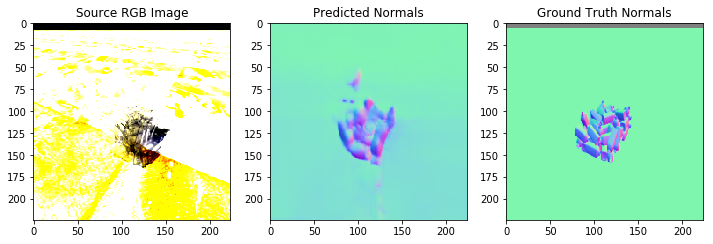

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


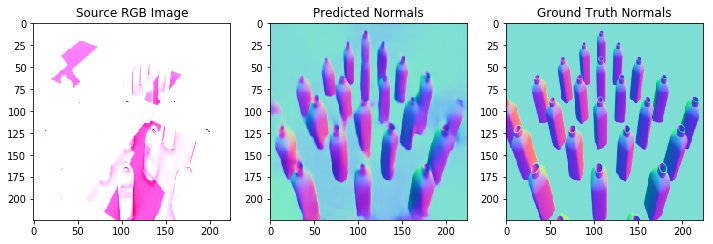

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


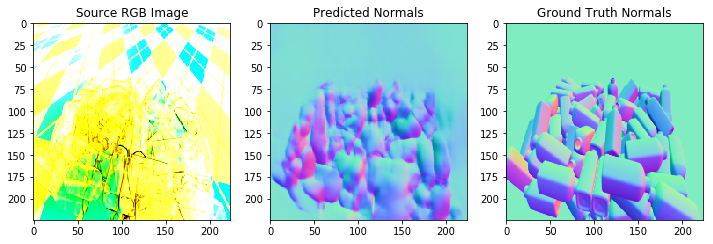

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


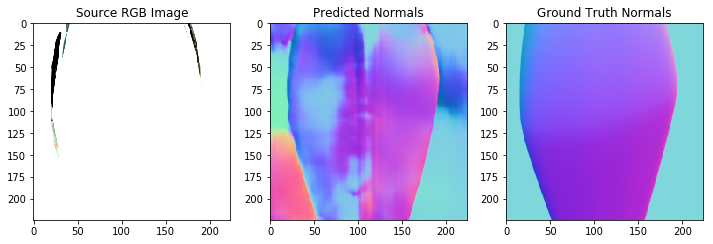

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


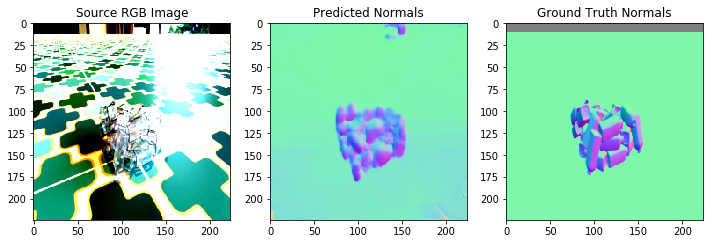

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


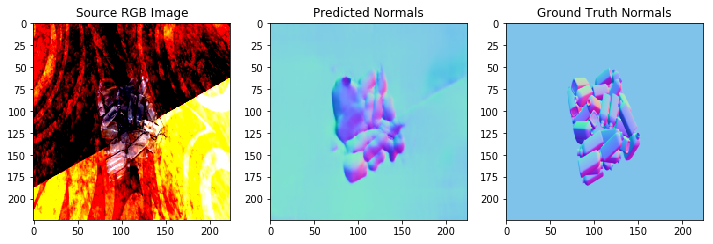

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


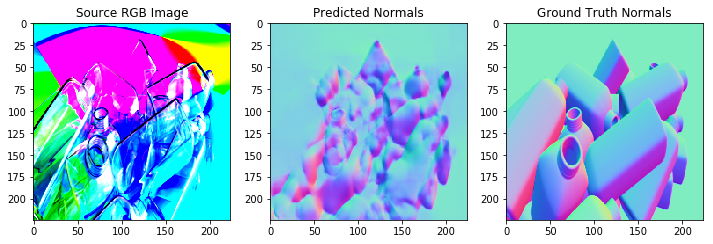

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


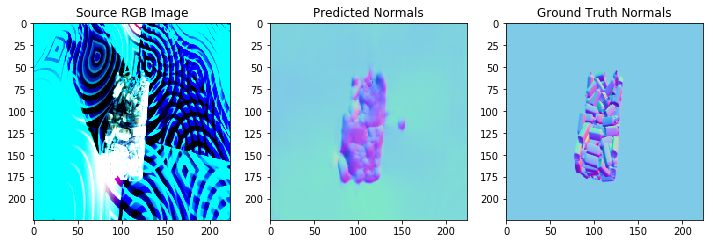

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


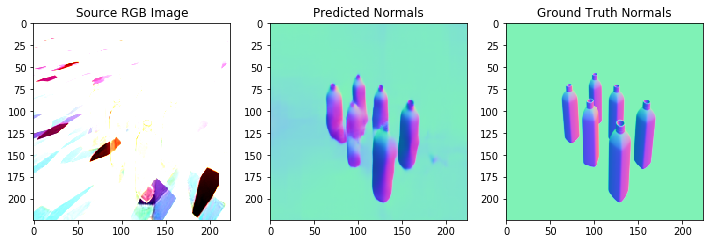

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


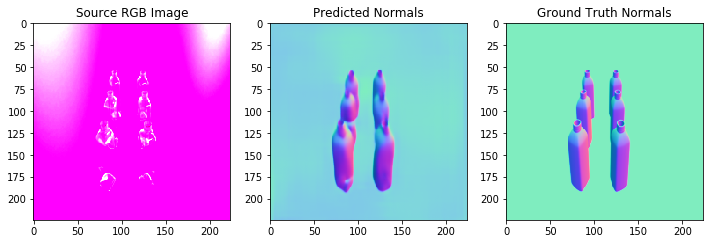

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


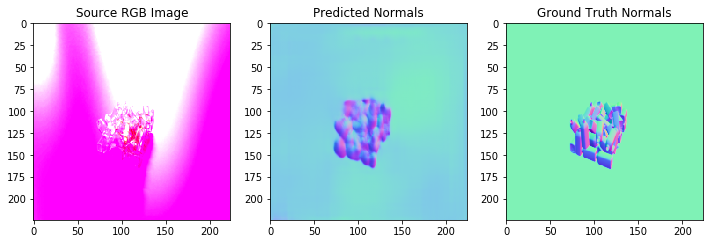

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [16]:
%matplotlib inline

import sys, os
from PIL import Image
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from torch.autograd import Variable
import models.unet_normals as unet
import numpy as np
from data_loader import Dataset,Options
from skimage.transform import resize
from skimage import img_as_uint

class OPT():
    def __init__(self):
        self.dataroot = './data/'
        self.file_list = './data/datalist'
        self.batchSize = 24
        self.shuffle = True
        self.phase = 'eval'
        self.num_epochs = 1000
        self.imsize = 224
        self.num_classes = int(3)
        self.gpu = '0'
        self.logs_path = 'logs/exp8'

opt = OPT()
dataloader = Dataset(opt)

device = torch.device("cuda:"+ opt.gpu if torch.cuda.is_available() else "cpu")



checkpoint_path = opt.logs_path + '/checkpoints/checkpoint-ep_75-iter_70.pth'


for i in range(1300, 1445, 10):
    # Open and Transform Img
    img_preprocessed = np.load('data/test/rgb-imgs-preprocessed/%09d-rgb.npy'%(i))
    img_tensor = torch.from_numpy(img_preprocessed)
    img = img_tensor.unsqueeze(0)

    # Send img to device
    img = Variable(img.to(device))

    # Load Model
    fcn = unet.Unet(num_classes=opt.num_classes)
    fcn.load_state_dict(torch.load(checkpoint_path))
    fcn.to(device)
    fcn.eval()

    # Inference
    res = fcn(img)
    res_norm = nn.functional.normalize(res, p=2, dim=1)
    output = res_norm.squeeze(0)
    output = output.data.cpu().numpy()

    
    ### Create Plots ##
    show_plots = True
    if (show_plots):
        # Orig image
        rgb_img = np.load('data/test/rgb-imgs-preprocessed/%09d-rgb.npy'%(i))
        rgb_img = np.transpose(rgb_img, (1,2,0))

        # Predicted Normals
        camera_normal_rgb = dataloader.normals_to_rgb_with_negatives(output)
        camera_normal_rgb = np.transpose(camera_normal_rgb, (1,2,0))

        # Ground Truth Normals
        truth_normal = np.load('data/test/test-surface-normals-preprocessed/%09d-cameraNormals.npy'%(i))
        truth_normal = truth_normal.transpose(1,2,0)
        truth_normal_resized = truth_normal
        truth_normal_resized = dataloader.normals_to_rgb_with_negatives(truth_normal_resized)

        fig = plt.figure(figsize=(12,12))
        ax0 = plt.subplot(131)
        ax1 = plt.subplot(132)
        ax2 = plt.subplot(133)
        ax0.imshow(rgb_img)
        ax0.set_title('Source RGB Image') # subplot 211 title
        ax1.imshow(camera_normal_rgb)
        ax1.set_title('Predicted Normals')
        ax2.imshow(truth_normal_resized)
        ax2.set_title('Ground Truth Normals')
        plt.show()
        plt.close('all')



    ### Save Images ###
    save_images = True
    if (save_images):
        # Orig image
        plt.imsave('data/results/test-results/%09d-rgb.png'%(i), rgb_img)

        # Predicted Normals
        plt.imsave('data/results/test-results/%09d-normals.png'%(i), camera_normal_rgb)

        # Ground Truth Normals
        plt.imsave('data/results/test-results/%09d-normals-groundtruth.png'%(i), truth_normal_resized)
    
    

    